In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = '/content/drive/MyDrive/Kvasir'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import os
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB7
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
#Defining paths
TRAIN_PATH = "/content/drive/MyDrive/Kvasir/Train"
TEST_PATH = "/content/drive/MyDrive/Kvasir/Test"

In [ ]:
BATCH_SIZE = 64

# 70:20:10 = Training data:Validation data:Testing data

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.222,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
traingen = train_generator.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(TEST_PATH,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 5608 images belonging to 8 classes.
Found 1592 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    pre_trained_model = EfficientNetB7(input_shape = input_shape, 
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet',drop_connect_rate=0)
    
    for layer in pre_trained_model.layers:
        layer.trainable = False


    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = pre_trained_model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=pre_trained_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=8

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 30

# First we'll train the model without Fine-tuning
EfficientNetB7_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)

In [ ]:
EfficientNetB7_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [ ]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
EfficientNetB7_history = EfficientNetB7_model.fit(traingen,                     
                                  batch_size=BATCH_SIZE,   
                                  epochs=n_epochs,
                                  validation_data=validgen, 
                                  steps_per_epoch=n_steps,    
                                  validation_steps=n_val_steps, 
                                  callbacks=[tl_checkpoint_1, early_stop],
                                  verbose=1)

Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 1.2705 - accuracy: 0.5386
Epoch 1: val_loss improved from inf to 0.94301, saving model to tl_model_v1.weights.best.hdf5
87/87 [==============================] - 262s 3s/step - loss: 1.2705 - accuracy: 0.5386 - val_loss: 0.9430 - val_accuracy: 0.6393
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 0.9189 - accuracy: 0.6571
Epoch 2: val_loss improved from 0.94301 to 0.90031, saving model to tl_model_v1.weights.best.hdf5
87/87 [==============================] - 227s 3s/step - loss: 0.9189 - accuracy: 0.6571 - val_loss: 0.9003 - val_accuracy: 0.6667
Epoch 3/30
87/87 [==============================] - ETA: 0s - loss: 0.8431 - accuracy: 0.6926
Epoch 3: val_loss improved from 0.90031 to 0.86260, saving model to tl_model_v1.weights.best.hdf5
87/87 [==============================] - 225s 3s/step - loss: 0.8431 - accuracy: 0.6926 - val_loss: 0.8626 - val_accuracy: 0.6790
Epoch 4/30
87/87 [====================

In [ ]:
# Generate predictions
EfficientNetB7_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

EfficientNetB7_preds = EfficientNetB7_model.predict(testgen)
EfficientNetB7_pred_classes = np.argmax(EfficientNetB7_preds, axis=1)

In [ ]:
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

In [ ]:
from sklearn.metrics import accuracy_score
EfficientNetB7_acc = accuracy_score(true_classes, EfficientNetB7_pred_classes)
print("EfficientNetB7 Model Accuracy: {:.2f}%".format(EfficientNetB7_acc * 100))

EfficientNetB7 Model Accuracy: 81.50%


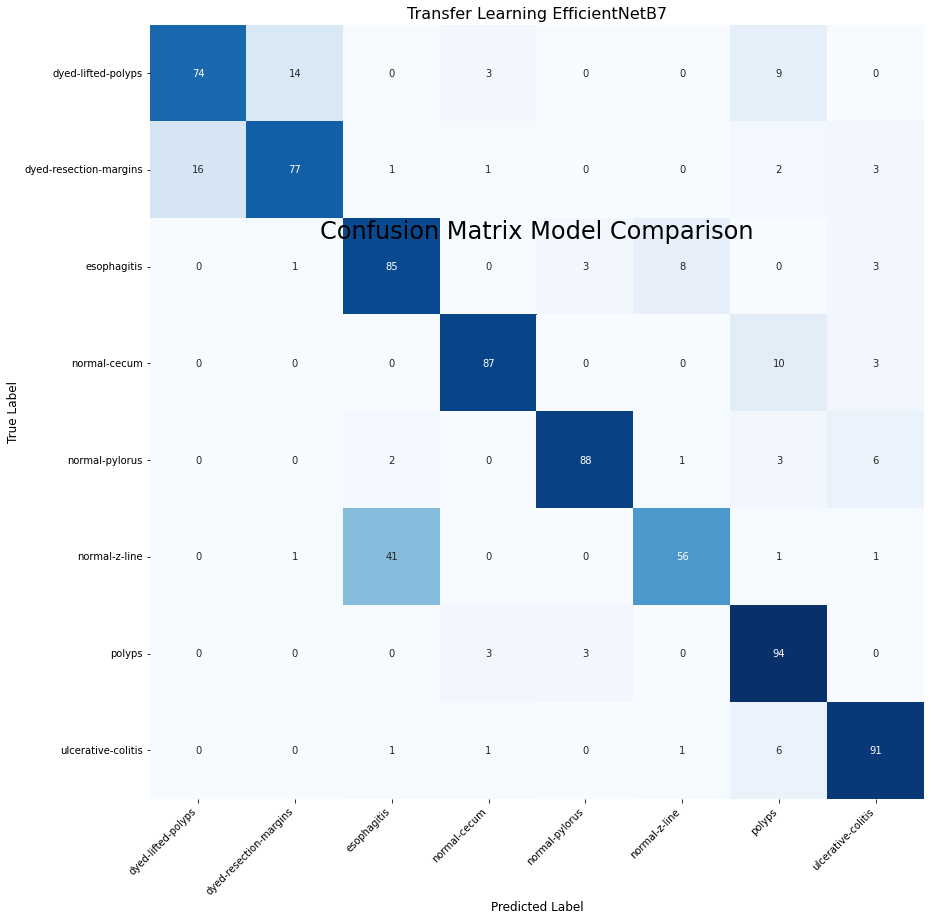

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1,figsize=(20, 10))
    
plot_heatmap(true_classes, EfficientNetB7_pred_classes, class_names, ax1, title="Transfer Learning EfficientNetB7")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()